In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile
import h5py 
import cupy as cp
import holotomo
import glob
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
n = 136
npos = 16
ndist = 1
data0 = np.zeros([npos,ndist,n,n],dtype='float32')
ref0 = np.zeros([1,n,n],dtype='float32')
dark = np.zeros([1,n,n],dtype='float32')

for k in range(5*16):
    file = glob.glob(f'/data/NSLSII/3ID/projection_image/*{205+k}.tif')
    data0[k//5] += tifffile.imread(file[0])[785:785+136,278:278+136]

for k in range(5):
    file = glob.glob(f'/data/NSLSII/3ID/projection_image/*{290+k}.tif')
    dark += tifffile.imread(file[0])[785:785+136,278:278+136]

for k in range(5):
    file = glob.glob(f'/data/NSLSII/3ID/projection_image/*{285+k}.tif')
    ref0 += tifffile.imread(file[0])[785:785+136,278:278+136]

ref0-=dark
data0-=dark
ref0[ref0<0] = 0
data0[data0<0] = 0
rdata = (data0)/(ref0+1e-6)

def plot_rec(sid=1):
    plt.figure(figsize=(8,6))
    plt.imshow(rdata[sid,0],cmap='gray',vmax=2)    
    plt.colorbar()
interact(plot_rec, sid = widgets.IntSlider(value=0,
                                               min=0,
                                               max=rdata.shape[0]-1,
                                               step=1))    

interactive(children=(IntSlider(value=0, description='sid', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_rec(sid=1)>

In [3]:
shifts_motor = [[0.5,   0.3 ], [0.1,   0.8 ], [0.7, 0.4   ], [0.3,   0.1 ],
          [0.7,   11.2], [0.5,   11.1], [0.2, 11.5  ], [0.3,   11.8],
          [-10.7, 0.3 ], [-10.5, 0.7 ], [-10.2, 0.4 ], [-10.9, 0.9 ],
          [-10.8, 11.4], [-10.5, 11.3], [-10.2, 11.8], [-10.4, 11.5],
          ]
shifts_motor = np.array(shifts_motor)


# Dark-flat field correction

# Init data sizes and parametes of the PXM of ID16A

In [4]:
voxelsize = 141.777e-9 # [m] object voxel size 
energy = 14  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.06 # [m]


z1 = np.array([2e-3])[:ndist] # positions of the sample (1 position is enough when using several codes)
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector
magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

# Read motor shifts

In [9]:
shifts = -shifts_motor[:,np.newaxis]/voxelsize*1e-6+np.array([-38,38])#*[0.98,0.95]

print(shifts)

[[[-41.52666511  35.88400093]]

 [[-38.70533302  32.35733582]]

 [[-42.93733116  35.17866791]]

 [[-40.11599907  37.29466698]]

 [[-42.93733116 -40.99729857]]

 [[-41.52666511 -40.29196555]]

 [[-39.41066605 -43.11329764]]

 [[-40.11599907 -45.22929671]]

 [[ 37.47063346  35.88400093]]

 [[ 36.05996741  33.06266884]]

 [[ 33.94396834  35.17866791]]

 [[ 38.88129951  31.65200279]]

 [[ 38.17596648 -42.40796462]]

 [[ 36.05996741 -41.7026316 ]]

 [[ 33.94396834 -45.22929671]]

 [[ 35.35463439 -43.11329764]]]


[[-41.52666511 -40.29196555]]


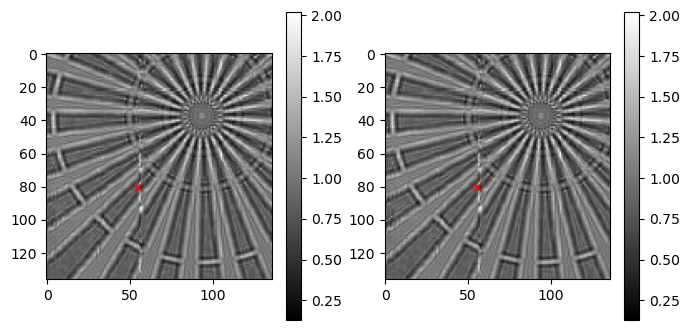

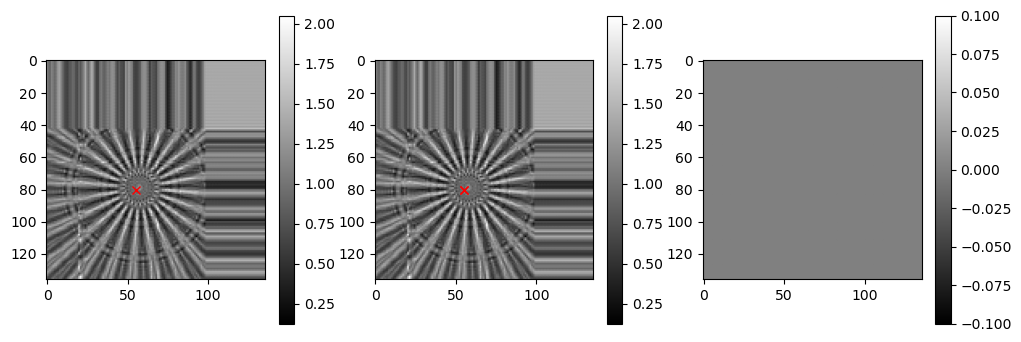

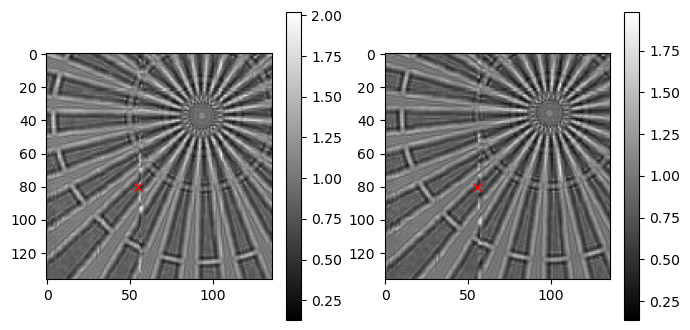

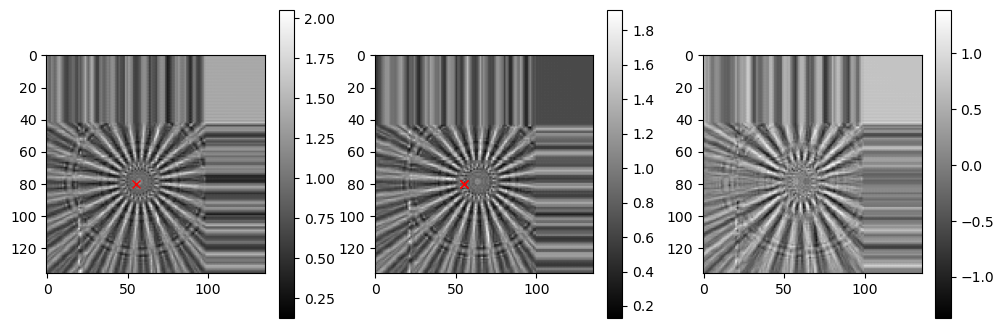

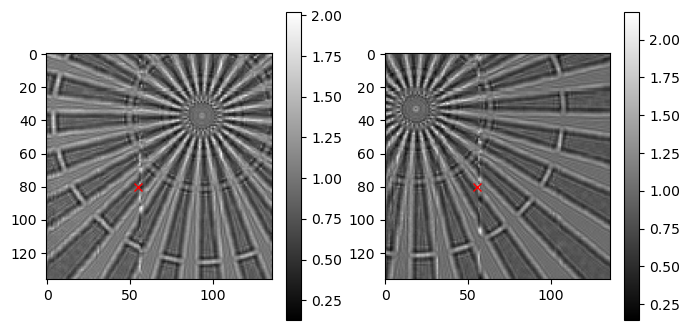

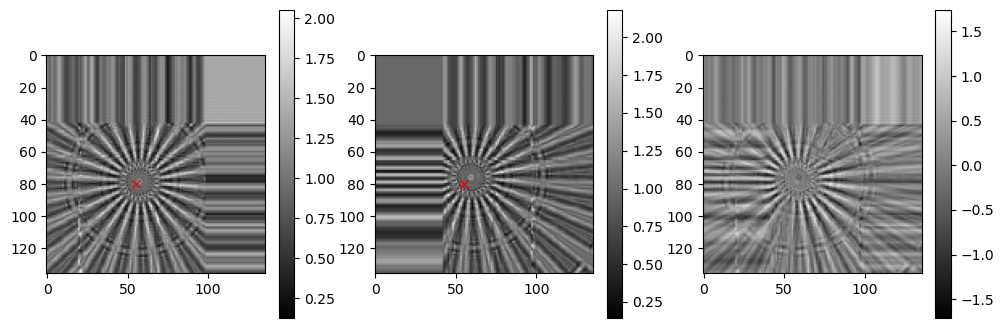

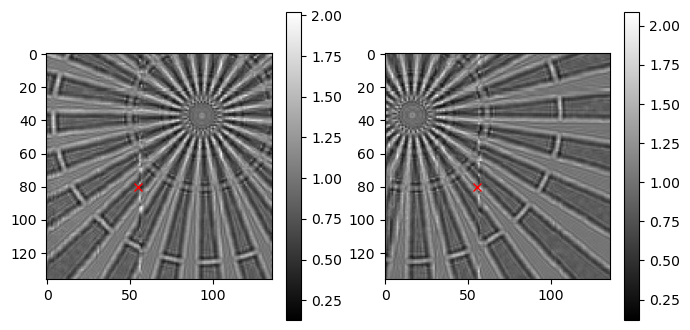

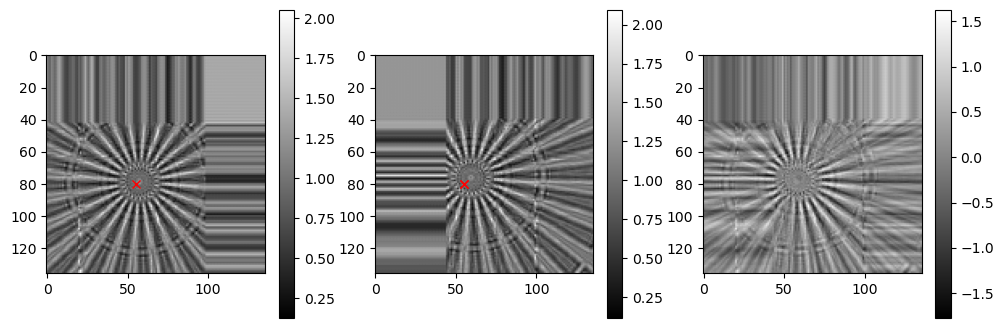

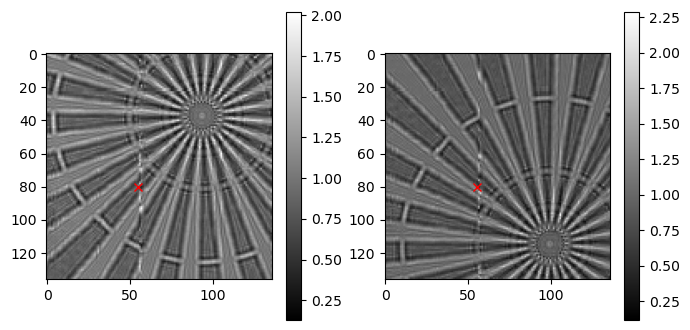

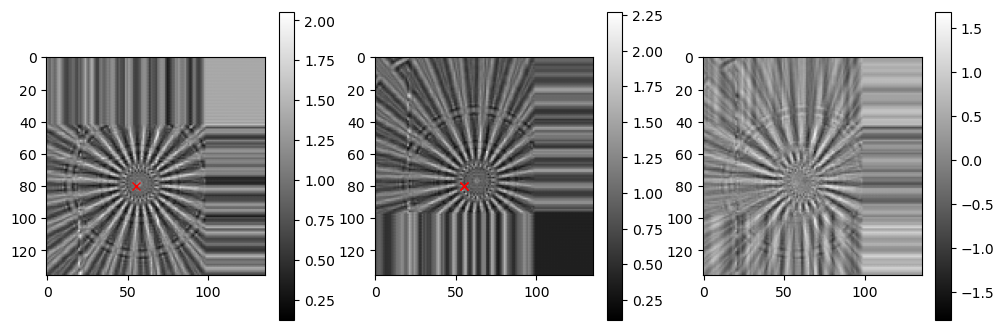

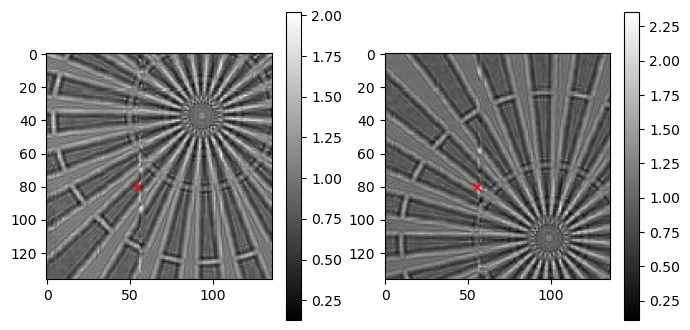

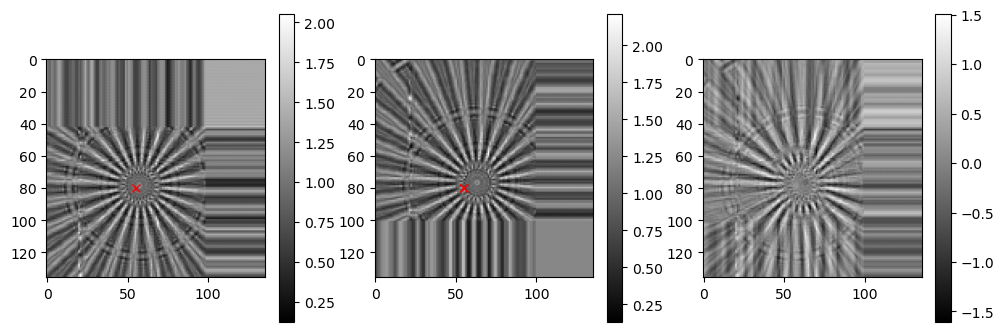

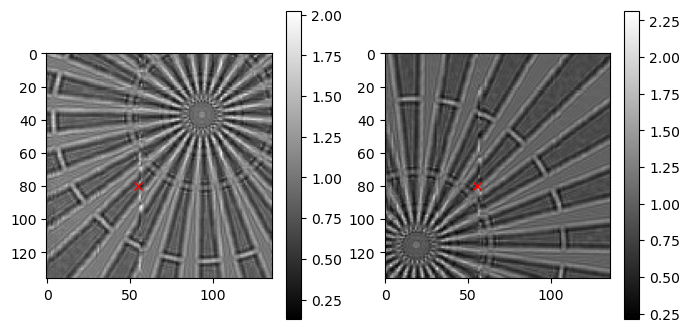

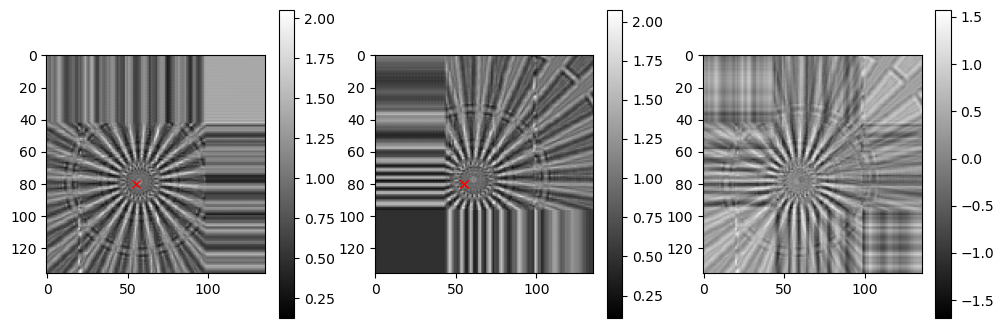

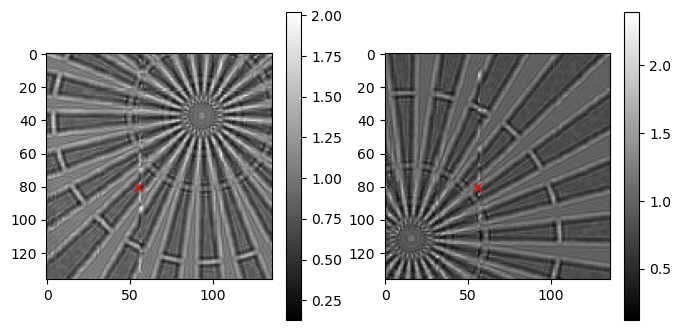

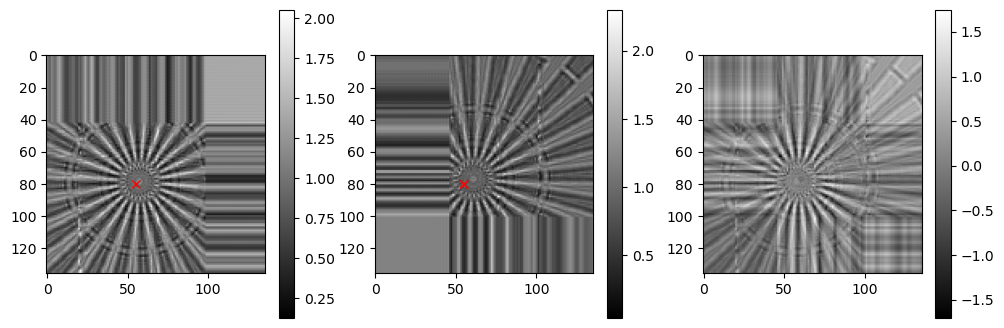

In [13]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'edge')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
                         
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_new = rdata.copy()    
for k in range(ndist):
    for j in range(npos):
        #print(f'shift for pos {k} dist {j} is {shifts[k,j]}')
        rdata_new[j,k:k+1] = apply_shift(rdata[j,k:k+1],-shifts[j,k:k+1])

print(shifts[5])
for k in range(0,npos,2):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    im=axs[0].imshow(rdata[0,0],cmap='gray')
    axs[0].plot(55,80,'rx')        
    fig.colorbar(im)
    im=axs[1].imshow(rdata[k,0],cmap='gray')
    axs[1].plot(55,80,'rx')        
    fig.colorbar(im)        
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))    
    im=axs[0].imshow(rdata_new[0,0],cmap='gray' )
    axs[0].plot(55,80,'rx')    
    fig.colorbar(im)        
    im=axs[1].imshow(rdata_new[k,0],cmap='gray' )
    axs[1].plot(55,80,'rx')
    fig.colorbar(im)            
    im=axs[2].imshow(rdata_new[0,0]-rdata_new[k,0],cmap='gray' )
    axs[1].plot(55,80,'rx')    
    fig.colorbar(im)        
    

# Scale everything to 1 magnification

# Total shifts in pixels before normalized scaling

In [121]:
data = data0[:,:,np.newaxis]# adding angular dim
ref = ref0.copy()

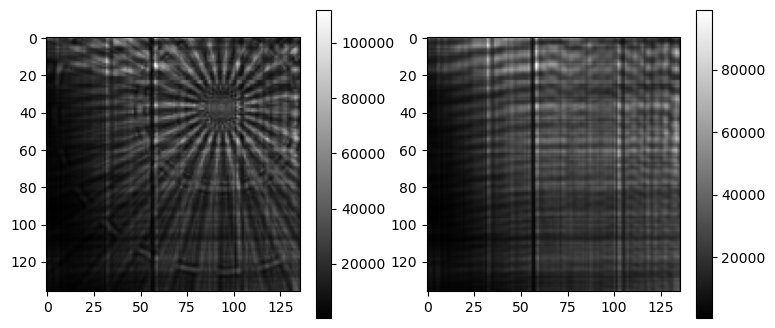

In [125]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(data[0,k,0],cmap='gray')
    fig.colorbar(im)
    im=axs[1].imshow(ref[k],cmap='gray')
    fig.colorbar(im)        
    

# Create solver class

In [126]:
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[0:1], norm_magnifications[0:1]) 

## Goal: recover the sample and probe simultaneously $\ \sum_i\sum_j||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi,q}$ 

$i$ - index for the NFP shifts\
$j$ - index for planes \
$\psi$ - sample at plane 0 \
$q$ - probe at plane 0\
$M_j$ - object normalized (de-)magnification for the plane $j$ \
$S_r$ - shift for distance r (x and y), NFP shifts + alignment shifts \
$\mathcal{G}_d$ - Fresnel transform for distance $d$

## Holotomography can be obtained by associating index $i$ with angles (no NFP)
## $\sum_i\sum_j||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi_i,q} $

## Define forward operators as 
### $\psi \to \mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_jS_{r_{ij}}\psi))$, where $i = 0 \dots 15$, $j = 0 \dots 3$ 
### $q \to \mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_jS_{r_{ij}}\psi))$, where $i = 0 \dots 15$, $j = 0 \dots 3$, 
## The adjoint operators are then 
### $\sigma[\psi]\to \sum_j\sum_i M_j^*S_{-r_{ij}}((\mathcal{G}_{d'_j}q)^*\mathcal{G}_{-d_{j}}\sigma)$, 
### $\sigma[q]\to \sum_j\sum_i \mathcal{G}_{-d'_j}((M_jS_{r_{ij}}\psi)^*\mathcal{G}_{-d_j}\sigma)$

# Check double propagation

[0.00199623] [0.]
(16, 1, 1, 136, 136)


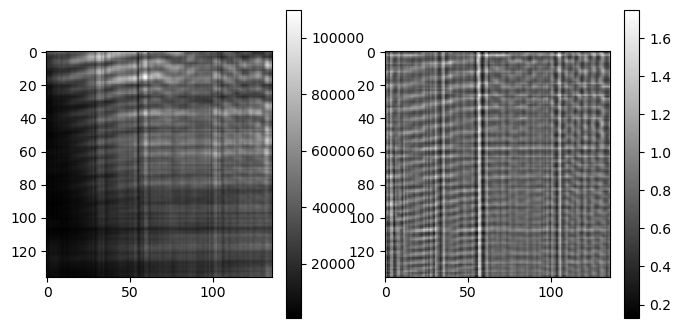

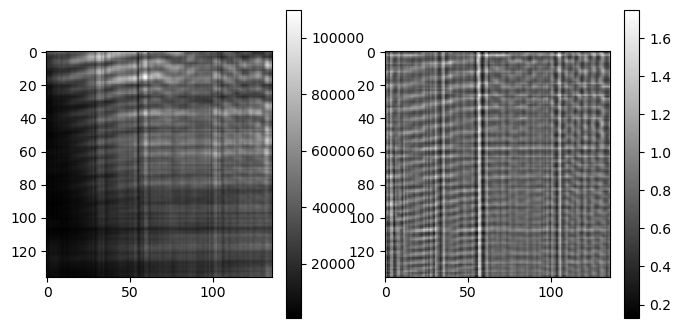

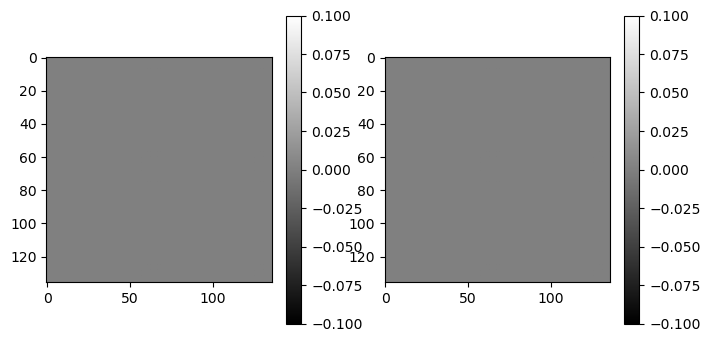

In [127]:
z1 = np.array([2e-3]) # positions of the sample
z1=z1[:ndist]
z2 = focusToDetectorDistance-z1 # propagation distance between the probe plane and detector
z1p = np.tile(z1[0],ndist) # positions of the sample
z2p = z1-z1p

magnifications = (z1+z2)/z1 # magnification when propagating from the probe plane to the sample
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes
distances = distances

magnifications2 = (z1p+z2p)/z1p # magnification when propagating from the sample to the detector
distances2 = (z1p*z2p)/(z1p+z2p) # propagation distances after switching from the point source wave to plane wave,
norm_magnifications2 = magnifications2/magnifications2[0] # normalized magnifications
distances2 = distances2*norm_magnifications2**2 # scaled propagation distances due to magnified probes
distances2 = distances2*(z1p/z1)**2

print(distances,distances2)
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2) 

print(data.shape)
# arr1 = cp.pad(cp.array(data+1j*data).astype('complex64'),((1,1),(1,1),(1,1),(n//2,n//2),(n//2,n//2)),'symmetric')
# prb1 = cp.array(ref+1j*ref).astype('complex64')
arr1 = cp.pad(cp.array(data[0,0]+1j*data[0,0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')


ddata1 = pslv.fwd_holo(arr1*0+1,prb1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im=axs[0].imshow(np.abs(ddata1[0,0].get()),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(ddata1[0,0].get()),cmap='gray')#,vmin=1,vmax=2.5)
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im=axs[0].imshow(np.abs(ddata1[-1,0].get()),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(ddata1[-1,0].get()),cmap='gray')#,vmin=1,vmax=2.5)
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im=axs[0].imshow(np.abs(ddata1[-1,0].get())-np.abs(ddata1[0,0].get()),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(ddata1[-1,0].get())-np.angle(ddata1[0,0].get()),cmap='gray')
fig.colorbar(im)

# Adjoint test for holography with double propagation

In [128]:
arr1 = cp.pad(cp.array(data[0,0]+1j*data[0,0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
print(arr1.shape)
print(prb1.shape)
arr2 = pslv.fwd_holo(arr1,prb1)
arr3 = pslv.adj_holo(arr2,prb1)
prb3 = pslv.adj_holo_prb(arr2,arr1)


print(cp.sum(arr1*cp.conj(arr3)))
print(cp.sum(arr2*cp.conj(arr2)))
print(cp.sum(prb1*cp.conj(prb3)))

(1, 272, 272)
(1, 136, 136)
(5.1462363e+22-1857502200000000j)
(5.146236e+22+7612557000000j)
(5.1462367e+22-2710719500000000j)


In [129]:
def fwd_nfp(pslv,psi,prb,shifts):
    fpsi = cp.zeros([shifts.shape[0],shifts.shape[1],1,n,n],dtype='complex64')
    for j in range(shifts.shape[0]):        
        fpsi[j] = pslv.fwd_holo(psi,prb,shifts[j])                      
    return fpsi

def adj_nfp(pslv,fpsi,prb,shifts):
    psi = cp.zeros([1,2*n,2*n],dtype='complex64')
    for j in range(shifts.shape[0]):        
        psi += pslv.adj_holo(fpsi[j],prb,shifts[j])                                   
    return psi

def adj_nfp_prb(pslv,fprb,psi,shifts):
    prb = cp.zeros([1,n,n],dtype='complex64')
    for j in range(shifts.shape[0]):        
        prb += pslv.adj_holo_prb(fprb[j],psi,shifts[j])           
    return prb

# Adjoint test

In [131]:
shifts = cp.array(shifts)
arr1 = cp.pad(cp.array(data[0,0]+1j*data[0,0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
arr2 = fwd_nfp(pslv,arr1,prb1,shifts)
arr3 = adj_nfp(pslv,arr2,prb1,shifts)
prb3 = adj_nfp_prb(pslv,arr2,arr1,shifts)

print(cp.sum(arr1*cp.conj(arr3)))
print(cp.sum(arr2*cp.conj(arr2)))
print(cp.sum(prb1*cp.conj(prb3)))

(6.5205926e+23-4.0347954e+16j)
(6.520592e+23+2657856000000j)
(6.5205926e+23-1.1808916e+16j)


## Gradient descent with the line search

In [138]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
    
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(pslv, data, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = fwd_nfp(pslv,psi,prb,shifts)            
            grad = adj_nfp(pslv,
               fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb,shifts)/cp.max(cp.abs(prb))**2/ndist**2
                    
            d = -grad    
            # line search
            fd = fwd_nfp(pslv, d, prb,shifts)
            gammapsi = line_search(minf, 1, fpsi, fd)
            psi = psi+gammapsi*d
            
            if i%step==0:
                fig, axs = plt.subplots(2, 2, figsize=(8, 8))
                im=axs[0,0].imshow(np.abs(psi[0].get()),cmap='gray')
                axs[0,0].set_title('reconstructed amplitude')
                fig.colorbar(im)
                im=axs[0,1].imshow(np.angle(psi[0].get()),cmap='gray')
                axs[0,1].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1,0].imshow(np.angle(psi[0,n//2:-n//2,n//2:-n//2].get()),cmap='gray')
                axs[1,0].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1,1].imshow(np.angle(psi[0,n//2+n//4:-n//2-n//4,n//2+n//4:-n//2-n//4].get()),cmap='gray')
                axs[1,1].set_title('reconstructed phase')
                fig.colorbar(im)
                plt.show()
                fpsi = fwd_nfp(pslv,psi,prb,shifts)                            
                err=minf(fpsi)            
                print(f'{i}) {gammapsi=}, {err=:1.5e}')    
           
        if upd_prb:
            fprb = fwd_nfp(pslv,psi,prb,shifts)
            gradprb = adj_nfp_prb(pslv,fprb-cp.sqrt(data)*cp.exp(1j*cp.angle(fprb)),psi,shifts)/cp.max(cp.abs(psi))**2/pslv.ntheta/ndist**2

            dprb = -gradprb
            # gradprb0 = gradprb
            # line search
            fdprb = fwd_nfp(pslv,psi, dprb,shifts)
            gammaprb = line_search(minf, 1, fprb, fdprb)
            prb = prb + gammaprb*dprb
            
            if i%step==0:
                fprb = fwd_nfp(pslv,psi,prb,shifts)
                err=minf(fprb)
                print(f'{i}) {gammaprb=}, {err=:1.5e}')    
        
    return psi,prb

def cg_holo_batch(pslv, data, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,:,ids])
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb



# Estimate probe using one reference image $\||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_{r_0}}\|^2_2\to \text{min}$, taken for distance 0


(1, 1, 1, 136, 136)
0) gammaprb=1, err=7.86274e-04
8) gammaprb=1, err=1.80580e-05
16) gammaprb=1, err=2.00215e-05
24) gammaprb=1, err=2.80935e-05


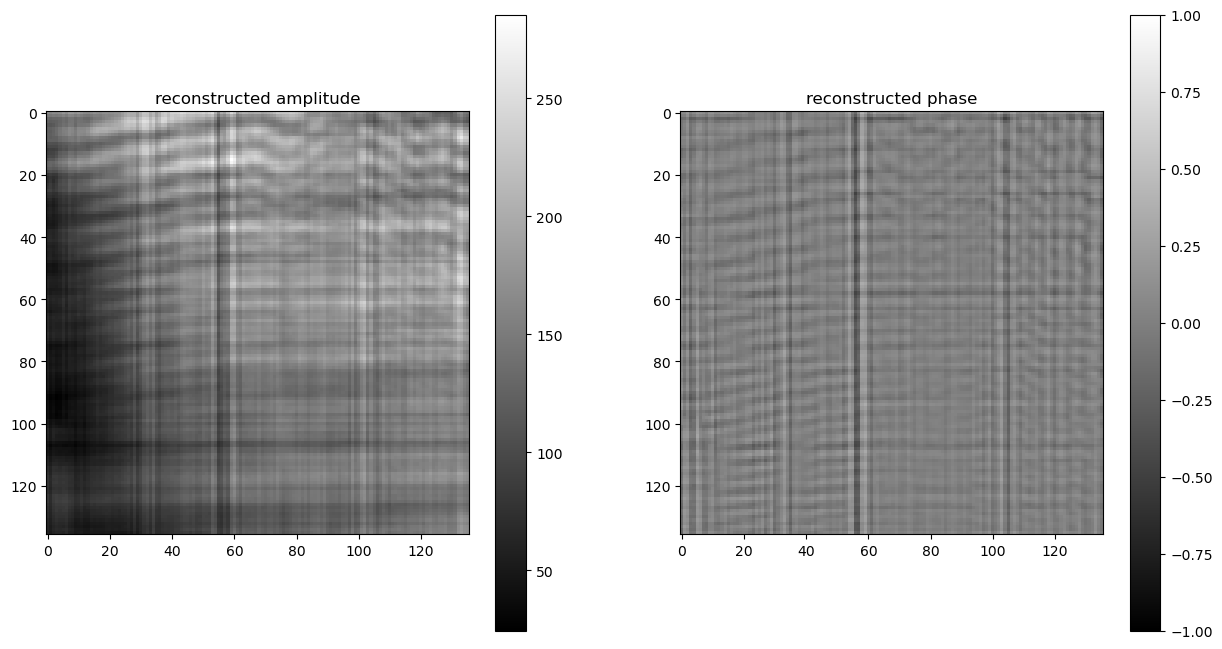

In [136]:
rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([1,n,n],dtype='complex64')        
data_ref = ref[:1,np.newaxis,np.newaxis]
print(data_ref.shape)
shifts_ref = (shifts/cp.array(norm_magnifications[:,np.newaxis]))[:1,:1]*0
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distances2[:1]) 
_,rec_prb = cg_holo_batch(pslv, data_ref, rec, rec_prb, 32, shifts_ref, False,True,8)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray',vmin=-1,vmax=1)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)


## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi,q}$ 

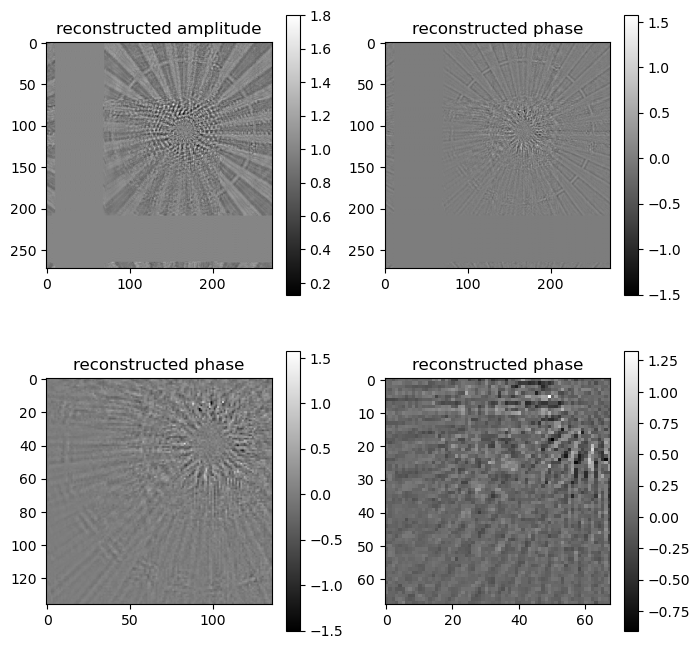

0) gammapsi=1, err=3.90223e+07
0) gammaprb=0.5, err=3.88787e+07


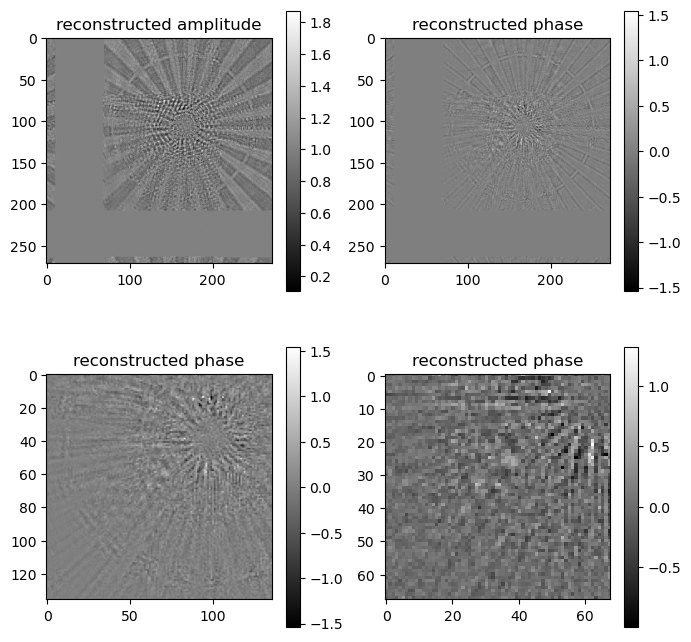

32) gammapsi=1, err=3.36919e+07
32) gammaprb=0.5, err=3.36710e+07


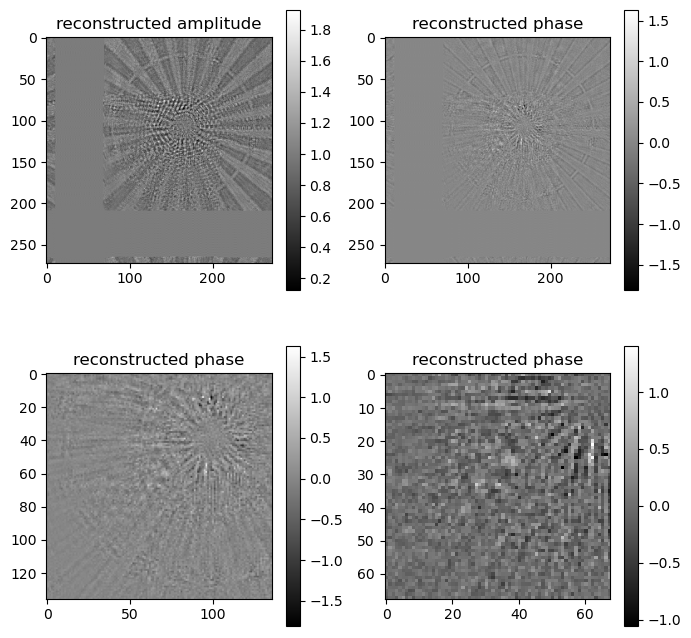

64) gammapsi=0.5, err=3.18541e+07
64) gammaprb=1, err=3.18392e+07


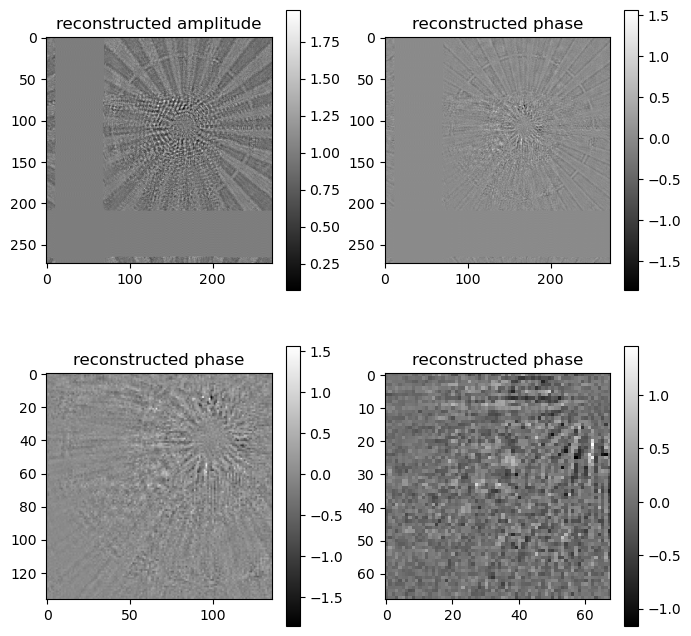

96) gammapsi=1, err=3.08994e+07
96) gammaprb=0.25, err=3.08669e+07


In [140]:

pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2) 
rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb, 128, shifts/cp.array(norm_magnifications[:,np.newaxis]), True,True,32)

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray',vmin=-0.07,vmax=0.07)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray',vmin=-1,vmax=1)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)